OSA11 charge loss model is fitted to lines at ~60 keV and 511 keV.
Trivial extrapolation of the evolution to 20 keV would lead to clear mismatch with ground calibration lines (applicable early mission) and cross-calibration obsevations (applicable late mission).

At ~22 keV there is a Cd line complex ([see](https://xdb.lbl.gov/Section1/Table_1-2.pdf)), but it's hard to use it due to several effects (in the order from more important to less important):
* low energy cut-off by pixel threshold. This effect appears as shift to high energy. The LE threshold can be only reasonably determined with astrophysical source observations.
* energy resolution. Since since the broadened line is cutoff at low energy, it unequally broadens to high energy. Resolution at LE can only be rather approximately determined with astrophysical source observations.
* underlying background is very variable at low energy, and sensitive to CR-induced activation. Also astrophysical sources brighter than 300 mCrab are comparable to background level, and bias energy estimation depending on the source spectrum, usually to high energy. It is possible to exclude particularly anomalous background conditions, but long-term trends are hard to disentangle from other effects.

For realistic magnitude of these effects, the shifts may lead to apparent line centroid from 20 to 30 keV, for actual line at 22 keV. See example below.



(1e-05, 10)

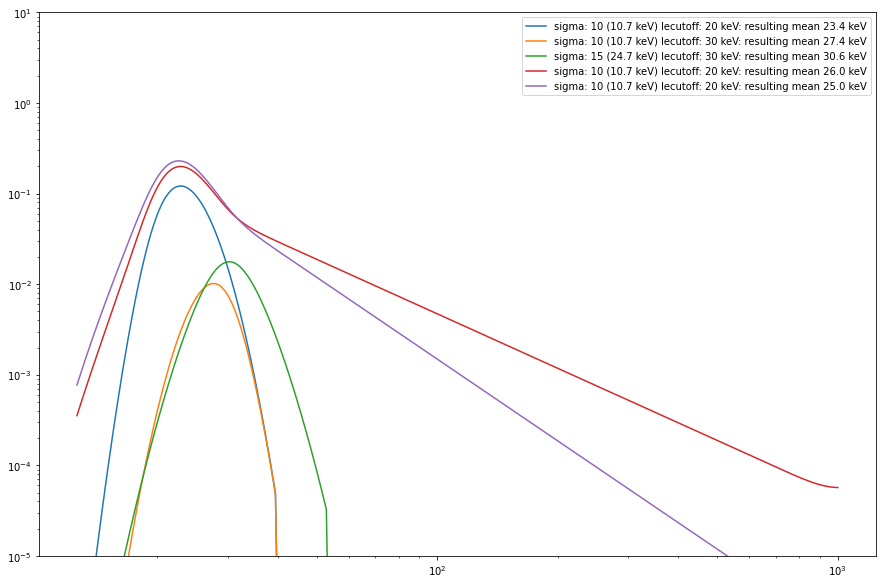

In [63]:
import numpy as np
from scipy.ndimage import gaussian_filter1d as g1d
from scipy.stats import norm
import matplotlib.pylab as plt

plt.figure(figsize=(15, 10))

en = np.logspace(1.1, 3, 300)


raw_line = norm(22, 0.1).pdf(en)

def leeffi(en, position=15, sharpness=14):
    return (en/position)**sharpness/(1+(en/position)**sharpness)

def observe(raw, sigma, lecutoff):
    return g1d(raw, sigma)*leeffi(en, lecutoff)


for sigma, lecutoff, extrabkg in [
    (10, 20, 0),
    (10, 30, 0),
    (15, 30, 0),    
    (10, 20, 0.05*(en/30)**-2),
    (10, 20, 0.05*(en/30)**-3),
]:
    m = en < 50
    obs_nole = observe(raw_line, sigma, 0.1)
    obs = observe(raw_line + extrabkg, sigma, lecutoff)

    mean = np.sum((en*obs)[m])/np.sum(obs[m])
    width = np.nansum((obs_nole*en**2)[m])/np.nansum(obs_nole[m]) - (np.nansum((obs_nole*en)[m])/np.nansum(obs_nole[m]))**2

    plt.plot(
        en,
        obs,
        label=f"sigma: {sigma} ({width:.1f} keV) lecutoff: {lecutoff} keV: resulting mean {mean:.1f} keV"
    )



plt.loglog()
plt.legend()

plt.ylim([1e-5, 10])

render_bipar default
m: 10
n: 3000
config 0: 0
first row: 22 31.642 46.099 330.68 2.2329 2.2329 8.1349 45.909 0.26057 0
config 0: 31.642
Finnished in 95 milliseconds. 
render_bipar default
m: 10
n: 3000
config 0: 0
first row: 59 32.458 123.1 41.074 3.7006 3.7006 7.2887 24.058 0.31234 0
config 0: 32.458
Finnished in 632 milliseconds. 
render_bipar default
m: 10
n: 3000
config 0: 0
first row: 150 31.495 314.55 7.0405 5.8185 5.8185 5.2964 12.6 0.22292 0
config 0: 31.495
Finnished in 869 milliseconds. 
render_bipar default
m: 10
n: 3000
config 0: 0
first row: 511 31.494 1071.6 5.279 10.739 10.739 1.5899 3.1552 0.077593 0
config 0: 31.494
Finnished in 827 milliseconds. 


Text(0, 0.5, 'RT (ISGRI Rise Time channel)')

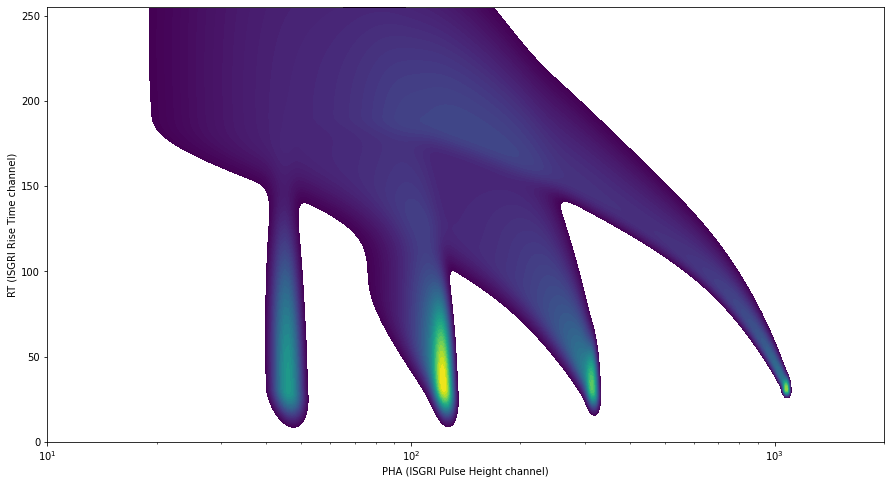

In [141]:
import sys
import os
import importlib

os.environ['EDDOSA_TOOLS_DIR'] = os.getcwd() + '/eddosa_tools/'

sys.path.insert(0, 'dda-ddosa')
sys.path.insert(0, 'dda-eddosa')
sys.path.insert(0, 'eddosa_tools/fit1d')

import lut2model
import bipar_model
import eddosa

#lut2model.render_bipar_m0()

bpm = eddosa.BiparModel()
bpm.bipar_model
det = bipar_model.detector()

pha_2d, rt_2d = np.meshgrid(np.arange(2048), np.arange(256))


bip = np.zeros_like(pha_2d, dtype=float)
    
for en in [22, 59, 150, 511]:
    _bip = bipar_model.make_bipar_monoenergetic(det, en).transpose()
    
    bip += _bip / np.nanquantile(_bip[_bip>_bip.max()/100].flatten(), 0.5)

plt.figure(figsize=(15, 8))
plt.contourf(pha_2d, rt_2d, bip**0.5, levels=np.logspace(-1, 0)*np.nanmax(bip**0.5))

plt.semilogx()
plt.xlim([10, 2000])

plt.xlabel('PHA (ISGRI Pulse Height channel)')
plt.ylabel('RT (ISGRI Rise Time channel)')

render_bipar default
m: 10
n: 3000
config 0: 0
first row: 22 31.642 11.072 330.68 2.2329 2.2329 8.1349 45.909 0.1046 0
config 0: 31.642
Finnished in 87 milliseconds. 
render_bipar default
m: 10
n: 3000
config 0: 0
first row: 59 32.458 29.566 41.074 3.7006 3.7006 7.2887 24.058 0.20803 0
config 0: 32.458
Finnished in 635 milliseconds. 
render_bipar default
m: 10
n: 3000
config 0: 0
first row: 511 31.494 257.38 5.279 10.739 10.739 1.5899 3.1552 0.24913 0
config 0: 31.494
Finnished in 852 milliseconds. 
render_bipar default
m: 10
n: 3000
config 0: 0
first row: 22 31.642 15.635 330.68 2.2329 2.2329 8.1349 45.909 0.13622 0
config 0: 31.642
Finnished in 90 milliseconds. 
render_bipar default
m: 10
n: 3000
config 0: 0
first row: 59 32.458 41.75 41.074 3.7006 3.7006 7.2887 24.058 0.24934 0
config 0: 32.458
Finnished in 624 milliseconds. 
render_bipar default
m: 10
n: 3000
config 0: 0
first row: 511 31.494 363.43 5.279 10.739 10.739 1.5899 3.1552 0.20353 0
config 0: 31.494
Finnished in 931 milli

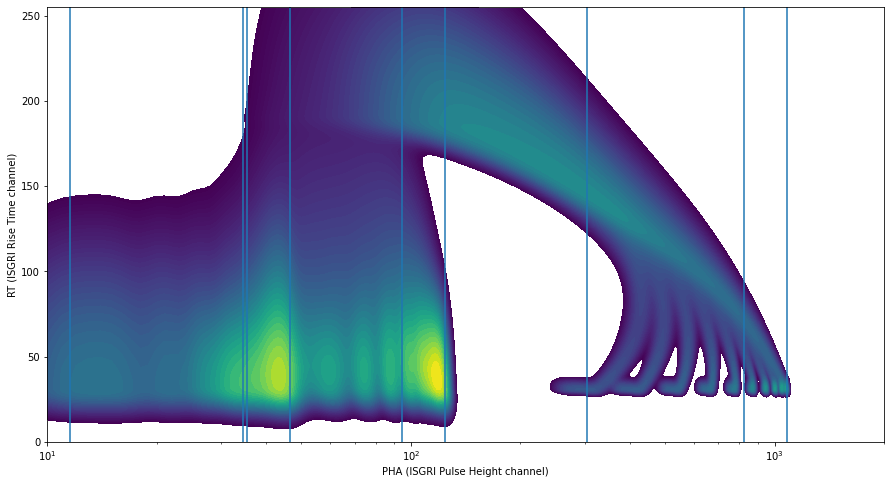

In [174]:
bip = np.zeros_like(pha_2d, dtype=float)

det_base = bipar_model.detector()

lrt_lines = []

for tau_loss_factor in np.logspace(-1.5, 0, 10):
    det = bipar_model.detector()
    det.tau_e = det_base.tau_e * tau_loss_factor

    for en in [22, 59, 511]:
        _bip = bipar_model.make_bipar_monoenergetic(det, en).transpose()

        ltr_bip = _bip[15:30, :].sum(0)
        lrt_lines.append(
            dict(
                energy=en,
                tau_e=det.tau_e,
                mean_pha=np.sum(pha_2d[0,:]*ltr_bip)/np.sum(ltr_bip)
            )
            )
        
        bip += _bip / np.nanquantile(_bip[_bip>_bip.max()/100].flatten(), 0.5)


plt.figure(figsize=(15, 8))
plt.contourf(pha_2d, rt_2d, bip**0.5, levels=np.logspace(-1, 0)*np.nanmax(bip**0.5))

plt.semilogx()
plt.xlim([10, 2000])

plt.xlabel('PHA (ISGRI Pulse Height channel)')
plt.ylabel('RT (ISGRI Rise Time channel)')

for vl in vlines:
    plt.axvline(vl)

Charge loss model, in principle, results in a prescription to how low-energy part evolves. This prescription is somewaht different from simple linear change of offset and gain. But not as different as what is observed at low energy.

Prescriptions for evolution at different energies are are shown below.

[]

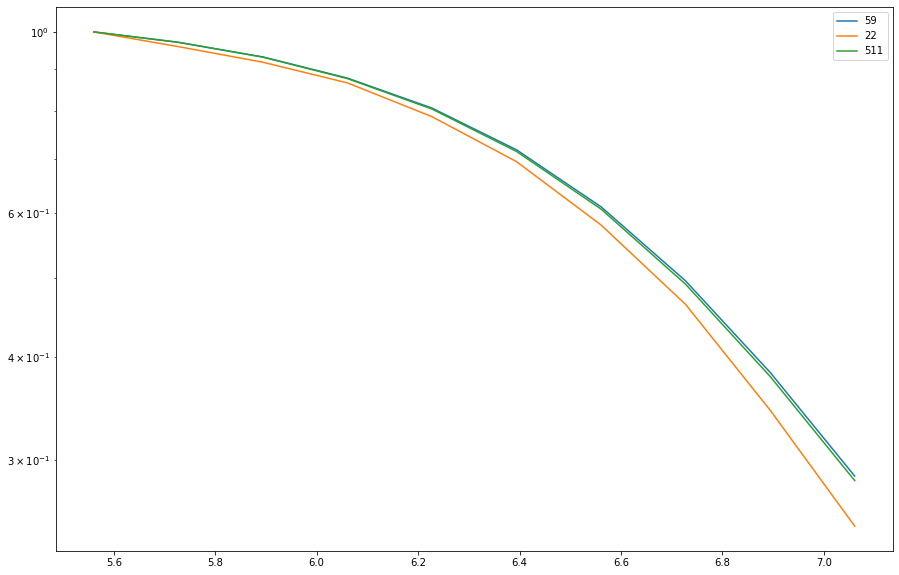

In [178]:
plt.figure(figsize=(15, 10))

for en in set([l['energy'] for l in lrt_lines]):
    mean_phas = np.array([l['mean_pha'] for l in lrt_lines if l['energy'] == en])
    plt.plot(
        [-np.log10(l['tau_e']) for l in lrt_lines if l['energy'] == en],
        mean_phas/mean_phas.max(),
        label=en
    )

plt.legend()
plt.semilogy()

However, observations with cyclotron line sources indicate excessive compression of energy scale by up to 10% at 30 keV (see https://linked-open-data.space/)

Roughly, the model predicts that PHA=30 corresponds to 30 keV in 2021. But we observe that PHA=30 corresponds to 20 keV.
It means that charge collection for 30 keV depositions (which all happen near the detector surface) remains efficient, despite substantial loss of electron lifetime, as seen in charge collection for 511 keV (which happens in the whole pixel).

#TODO: deduce gain evolution just from the first line, assuming constant offset.

There are not many ways to explain this. The best I can suggest for now is changes in detector homogenuity: polarization and/or charge carrier properties.

#TODO: combine and estimate field and detector properties inhomegenuity effect
#TODO: model field inhomogenuity to see what it does?

Astro observations seems to suggest that constant offset would work.